# Fine Tunning  a pretrained LLM (DistilBert)

DistilBERT is a small, fast, cheap and light Transformer model based on the BERT architecture. Knowledge distillation is performed during the pre-training phase to reduce the size of a BERT model by 40%.

References: 
- DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter [https://arxiv.org/abs/1910.01108v4]
- https://huggingface.co/docs/transformers/model_doc/distilbert

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "BERT-FineTunned"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input-FineTunning (InputLa  [(None, 32)]                 0         []                            
 yer)                                                                                             
                                                                                                  
 Mask-fineTunning (InputLay  [(None, 32)]                 0         []                            
 er)                                                                                              
                                                                                                  
 tf_distil_bert_model_17 (T  TFBaseModelOutput(last_hid   6636288   ['Input-FineTunning[0][0]',   
 FDistilBertModel)           den_state=(None, 32, 768),   0          'Mask-fineTunni

C:\Users\jayanti.prasad\Anaconda3\envs\aiml_env\lib\site-packages\transformers\tokenization_utils_base.py:2622: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch 1/20


C:\Users\jayanti.prasad\Anaconda3\envs\aiml_env\lib\site-packages\keras\src\backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


50/50 [==============================] - 26s 469ms/step - loss: 6.8152 - accuracy: 0.4875 - val_loss: 6.6217 - val_accuracy: 0.5500
Epoch 2/20
50/50 [==============================] - 23s 467ms/step - loss: 6.5600 - accuracy: 0.5100 - val_loss: 6.3799 - val_accuracy: 0.6000
Epoch 3/20
50/50 [==============================] - 24s 473ms/step - loss: 6.3010 - accuracy: 0.5650 - val_loss: 6.1482 - val_accuracy: 0.6350
Epoch 4/20
50/50 [==============================] - 25s 497ms/step - loss: 6.0898 - accuracy: 0.5288 - val_loss: 5.9287 - val_accuracy: 0.6450
Epoch 5/20
50/50 [==============================] - 24s 480ms/step - loss: 5.8817 - accuracy: 0.5512 - val_loss: 5.7160 - val_accuracy: 0.6600
Epoch 6/20
50/50 [==============================] - 25s 507ms/step - loss: 5.6641 - accuracy: 0.5500 - val_loss: 5.5151 - val_accuracy: 0.6550
Epoch 7/20
50/50 [==============================] - 25s 500ms/step - loss: 5.4676 - accuracy: 0.5600 - val_loss: 5.3232 - val_accuracy: 0.6450
Epoch 8/20

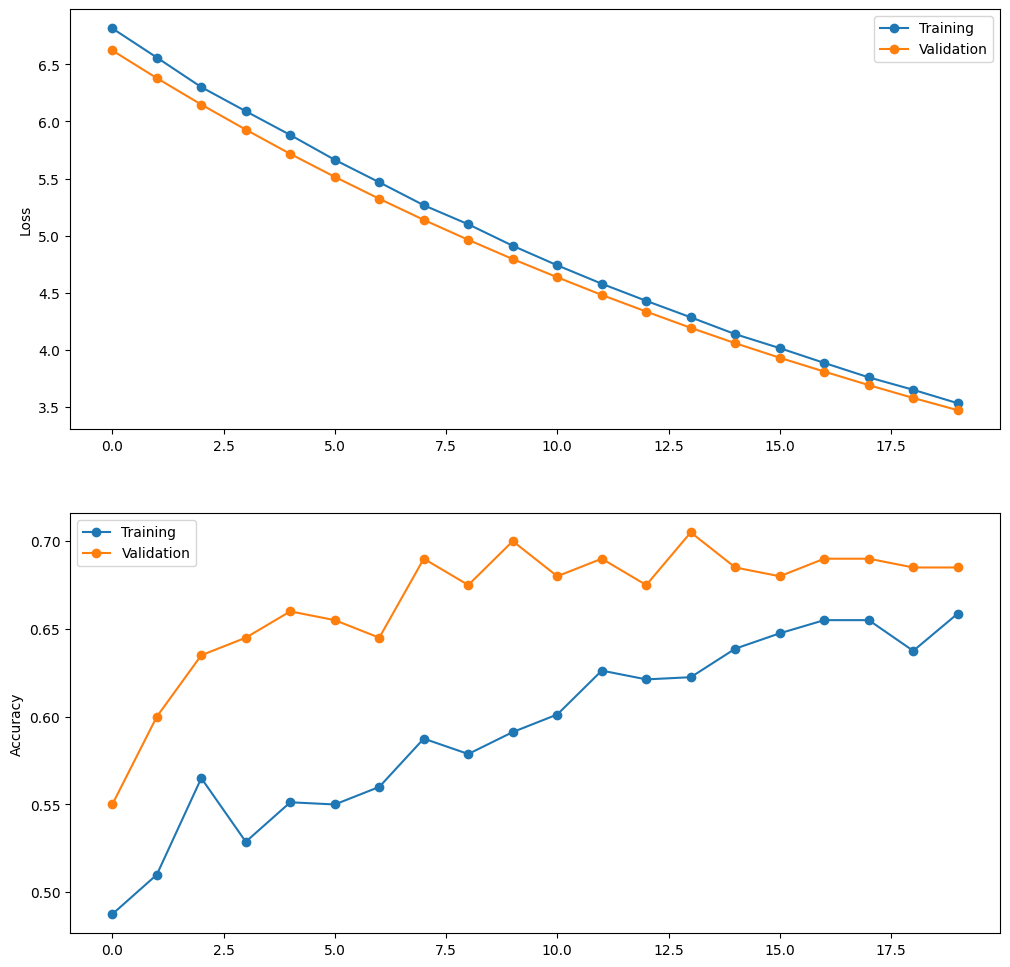

In [31]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from transformers import TFDistilBertModel,DistilBertTokenizer,DistilBertConfig
from sklearn.model_selection import train_test_split


# get tokenizer & Model 
dbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
dbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
 
file_path = r"C:\Users\jayanti.prasad\Data\NLP_DATA\train\IMDB_reviews.csv" 
# https://www.kaggle.com/datasets/jayantiprasad/imdb-movies-sentiment


def bert_preproc (sentences):
    # Prepare the model input
    input_ids = []
    attention_masks = []

    for sent in sentences:
        dbert_inps = dbert_tokenizer.encode_plus(sent, add_special_tokens=True, max_length=max_len,
                                                 pad_to_max_length=True, return_attention_mask=True, truncation=True)
        input_ids.append(dbert_inps['input_ids'])
        attention_masks.append(dbert_inps['attention_mask'])

    input_ids = np.asarray(input_ids)
    attention_masks = np.array(attention_masks)
    return input_ids, attention_masks
    
class BERT_FineTunning:
    def __init__(self, max_len,num_classes):
        self.max_len = max_len
        self.num_classes = num_classes 
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
        self.__get_model ()

    def __get_model (self,):
        inps = Input(shape=(max_len,), dtype='int64',name='Input-FineTunning')
        masks = Input(shape=(max_len,), dtype='int64',name='Mask-fineTunning')
        dbert_layer = dbert_model(inps, attention_mask=masks)[0][:, 0, :]
        dense = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01),name='Output-Dense1')(dbert_layer)
        dropout = Dropout(0.5,name='Dropout')(dense)
        pred = Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01),name='Output-Dense2')(dropout)
        self.model = tf.keras.Model(inputs=[inps, masks], outputs=pred,name='BERT-FineTunned')
        self.model.layers[2].trainable = False
        self.model.layers[3].trainable = False

    def train_model (self, workspace, train_inp, train_mask, train_label, val_inp, val_mask, val_label,num_epochs):
        log_dir = workspace + os.sep + 'log'

        if os.path.exists(log_dir) and os.path.isdir(log_dir):
            shutil.rmtree(log_dir)

        os.makedirs(log_dir, exist_ok=True)
        model_save_path = workspace + os.sep +  'dbert_model.h5'
        chkpt = ModelCheckpoint(filepath = model_save_path, save_weights_only=True, monitor='val_loss',
                                               mode='min', save_best_only=True)
        tboard = TensorBoard(log_dir=log_dir)
        callbacks = [chkpt, tboard]

        self.model.compile(loss=self.loss, optimizer=self.optimizer, metrics=[self.metric])
        history = self.model.fit([train_inp, train_mask], train_label, batch_size=16, epochs=num_epochs,
                            validation_data=([val_inp, val_mask], val_label), callbacks=callbacks)
        return history



def plot_history(history):
    fig, axs = plt.subplots(2, 1, figsize=(12, 12))

    axs[0].set_ylabel("Loss")
    axs[1].set_ylabel("Accuracy")

    axs[1].plot(history.history['accuracy'], '-o', label="Training")
    axs[1].plot(history.history['val_accuracy'], '-o', label='Validation')
    axs[0].plot(history.history['loss'], '-o', label='Training')
    axs[0].plot(history.history['val_loss'], '-o', label='Validation')

    axs[0].legend()
    axs[1].legend()
    plt.legend()
    plt.show()


if __name__ == "__main__":
    max_len = 32
    num_labels = 2
    workspace = "tmp"
    num_epochs = 20



    M = BERT_FineTunning (max_len, num_labels)
    print(M.model.summary())
    
    df = pd.read_csv(file_path, encoding='utf-8',nrows=1000)

    labels = df['label'].to_list()
    labels = np.array(labels)
    sentences = df['text'].to_list()
    
    input_ids, attention_masks  = bert_preproc (sentences)

    
    label_class_dict = {0: 'n', 1: 'y'}
    target_names = label_class_dict.values()

    train_inp, val_inp, train_label, val_label, train_mask, val_mask \
        = train_test_split(input_ids, labels,attention_masks, test_size=0.2)

    history = M.train_model(workspace, train_inp, train_mask, train_label, val_inp, val_mask, val_label,num_epochs)
    plot_history(history)

